In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import glob
import os
import skimage
import cv2

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import random 
from sklearn.model_selection import train_test_split


import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
import tensorflow as tf
from sklearn.metrics import classification_report,confusion_matrix

In [3]:
dir = r'image/images/images/'
#dir = r'/content/drive/MyDrive/OESON internship/ImageProcessingProject/data/images/images/'
all_files = glob.glob(os.path.join(dir, "*.jpg"))

Initial Read, including resizing and clearing of None images

In [4]:
img_size = 224
labels = os.listdir(dir)
data = []
folders = []
for label in labels:
  folders.append(os.path.join(dir, label))

error_count = 0
class_num = -1
for folder in folders:
  class_num += 1
  for img in os.listdir(folder):
    try:
      img_arr = cv2.imread(os.path.join(folder, img))
      resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
      data.append([resized_arr, class_num])

    except Exception as e:
      error_count +=1
  print("class_"+str(class_num)+" Read Complete")
print(error_count, "fails to read")



class_0 Read Complete
class_1 Read Complete
class_2 Read Complete
class_3 Read Complete
167 fails to read


In [194]:
print(len(data) + error_count)
print(error_count/(len(data) + error_count)*100)

35095
0.4758512608633709


167 of the data points provided failed to be read into the program, likely empty images. However 167/35095 is only around 0.5% of the total dataset, so negligible.

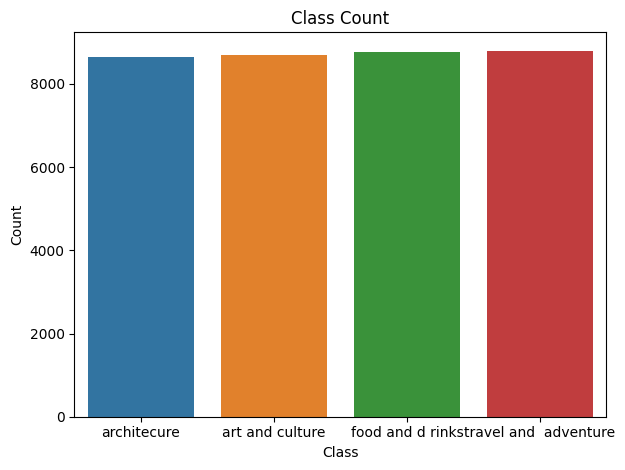

In [190]:
d = {0:[0], 1:[0],2:[0],3:[0]}

labels = []
for label in folders:
    labels.append(label.replace('image/images/images/', ''))

for i,j in data:
    d[j][0] = d[j][0]+1

d = pd.DataFrame(d)
d[labels]=d[[0,1,2,3]]
d=d[labels]

fig = sns.barplot(d).set(title='Class Count', xlabel = 'Class', ylabel = 'Count')
plt.tight_layout()

Spread of data even throughout the classes.

In [5]:
def get_sample(data, sample_size=1000, test_size=0.2, random_state=0):
    s = random.sample(data, sample_size)
    x=[]
    y=[]
    for feature, label in s:
        if feature is None: #check to see if has image
            continue
        x.append(feature)
        y.append(label)

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state)

    x_train = np.array(x_train) / 255 #Changing colour values to decimal percentages
    x_train.reshape(-1, img_size, img_size, 1) #
    y_train = np.array(y_train)

    x_test = np.array(x_test) / 255
    x_test.reshape(-1, img_size, img_size, 1) #
    y_test = np.array(y_test)
        
    return [x_train, y_train, x_test,  y_test]

In [73]:
sample = get_sample(data, sample_size=4000, test_size=0.2, random_state=0)


Producing the sample used to carry out the inital model trials. This is only 4000 entries (approximately 800 train cases per class), however its lower resource needs will make model testing faster, and when an ideal model has been found, this sample size can be upped to improve accuracy.

Defining model training and history graphing functions

In [10]:
def train_model(model, data, learning_rate=0.00001, num_epochs=30):
    opt = Adam(learning_rate=learning_rate)
    model.compile(optimizer = opt , loss = "sparse_categorical_crossentropy" , metrics = ['accuracy'])
    history = model.fit(data[0],data[1],epochs = num_epochs , validation_data = (data[2], data[3]))
    return history

In [11]:
def graph_history(history, modelnum='#', num_epochs=30):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(num_epochs)

    plt.figure(figsize=(15, 15))
    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Model '+str(modelnum)+' Training and Validation Accuracy')

    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Model '+str(modelnum)+' Training and Validation Loss')
    plt.show()
    return

In [96]:
def compare_history(history1, history2, modelnum1='#', modelnum2='#', num_epochs=50):
    acc1 = history1.history['accuracy']
    val_acc1 = history1.history['val_accuracy']
    loss1 = history1.history['loss']
    val_loss1 = history1.history['val_loss']

    acc2 = history2.history['accuracy']
    val_acc2 = history2.history['val_accuracy']
    loss2 = history2.history['loss']
    val_loss2 = history2.history['val_loss']

    epochs_range = range(num_epochs)

    plt.figure(figsize=(15, 15))
    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, acc1, label='Training Accuracy M'+str(modelnum1))
    plt.plot(epochs_range, val_acc1, label='Validation Accuracy M'+str(modelnum1))
    plt.plot(epochs_range, acc2, label='Training Accuracy M'+str(modelnum2))
    plt.plot(epochs_range, val_acc2, label='Validation Accuracy M'+str(modelnum2))
    plt.legend(loc='lower right')
    plt.title('Model Comparison Training and Validation Accuracy')

    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, loss1, label='Training Loss M'+str(modelnum1))
    plt.plot(epochs_range, val_loss1, label='Validation Loss M'+str(modelnum1))
    plt.plot(epochs_range, loss2, label='Training Loss M'+str(modelnum2))
    plt.plot(epochs_range, val_loss2, label='Validation Loss M'+str(modelnum2))
    plt.legend(loc='upper right')
    plt.title('Model Comparison Training and Validation Loss')
    plt.show()
    return

Initially can start our model testing with 1 convolution and 1 dense layer, with relu activations.

Model 1
1 convolution layer
1 dense layer

In [74]:
model1 = Sequential()

model1.add(Conv2D(16,(3,3),1, activation="relu", input_shape=(224,224,3)))
model1.add(MaxPool2D())

model1.add(Flatten())

model1.add(Dense(128,activation="relu"))
model1.add(Dense(4, activation="softmax"))

model1.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_29 (Conv2D)          (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d_29 (MaxPooli  (None, 111, 111, 16)      0         
 ng2D)                                                           
                                                                 
 flatten_16 (Flatten)        (None, 197136)            0         
                                                                 
 dense_36 (Dense)            (None, 128)               25233536  
                                                                 
 dense_37 (Dense)            (None, 4)                 516       
                                                                 
Total params: 25234500 (96.26 MB)
Trainable params: 25234500 (96.26 MB)
Non-trainable params: 0 (0.00 Byte)
___________

In [75]:
history1 = train_model(model1, sample, num_epochs=50)

Epoch 1/50
100/100 [==============================] - 24s 228ms/step - loss: 1.2089 - accuracy: 0.4372 - val_loss: 1.1236 - val_accuracy: 0.4837
Epoch 2/50
100/100 [==============================] - 22s 216ms/step - loss: 1.0609 - accuracy: 0.5422 - val_loss: 1.0179 - val_accuracy: 0.5838
Epoch 3/50
100/100 [==============================] - 21s 215ms/step - loss: 0.9934 - accuracy: 0.5903 - val_loss: 1.0166 - val_accuracy: 0.5775
Epoch 4/50
100/100 [==============================] - 22s 217ms/step - loss: 0.9495 - accuracy: 0.6112 - val_loss: 0.9765 - val_accuracy: 0.5962
Epoch 5/50
100/100 [==============================] - 22s 223ms/step - loss: 0.9148 - accuracy: 0.6331 - val_loss: 0.9940 - val_accuracy: 0.5863
Epoch 6/50
100/100 [==============================] - 23s 226ms/step - loss: 0.8632 - accuracy: 0.6525 - val_loss: 0.9596 - val_accuracy: 0.5925
Epoch 7/50
100/100 [==============================] - 22s 221ms/step - loss: 0.8261 - accuracy: 0.6762 - val_loss: 0.9630 - val_ac

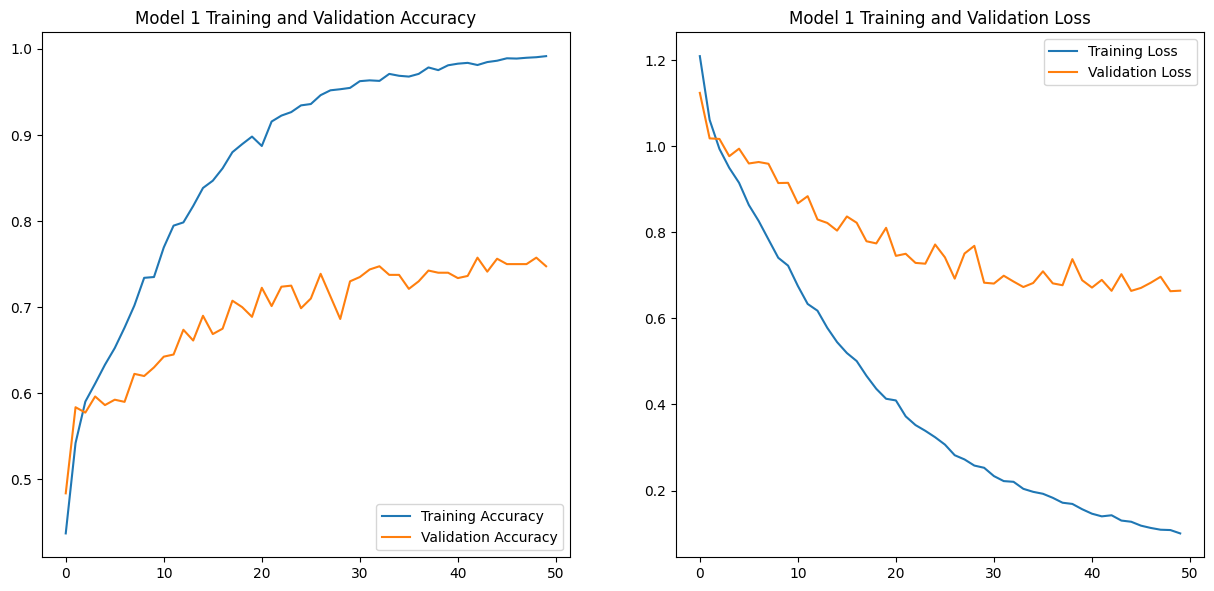

In [76]:
graph_history(history1,1, num_epochs=50)

Model 2
2 convolution layer 
1 dense layer

added another convolution layer to model1

In [77]:
model2 = Sequential()

model2.add(Conv2D(16,(3,3),1, activation="relu", input_shape=(224,224,3)))
model2.add(MaxPool2D())

model2.add(Conv2D(16,(3,3),1, activation="relu"))
model2.add(MaxPool2D())

model2.add(Flatten())

model2.add(Dense(128,activation="relu"))
model2.add(Dense(4, activation="softmax"))
model2.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 111, 111, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_31 (Conv2D)          (None, 109, 109, 16)      2320      
                                                                 
 max_pooling2d_31 (MaxPooli  (None, 54, 54, 16)        0         
 ng2D)                                                           
                                                                 
 flatten_17 (Flatten)        (None, 46656)             0         
                                                                 
 dense_38 (Dense)            (None, 128)             

In [44]:
history2 = train_model(model2, sample, num_epochs=50)

Epoch 1/50
100/100 [==============================] - 13s 126ms/step - loss: 1.2969 - accuracy: 0.3975 - val_loss: 1.2349 - val_accuracy: 0.4663
Epoch 2/50
100/100 [==============================] - 11s 115ms/step - loss: 1.1757 - accuracy: 0.4881 - val_loss: 1.1723 - val_accuracy: 0.5050
Epoch 3/50
100/100 [==============================] - 11s 114ms/step - loss: 1.1134 - accuracy: 0.5328 - val_loss: 1.1435 - val_accuracy: 0.5113
Epoch 4/50
100/100 [==============================] - 11s 113ms/step - loss: 1.0750 - accuracy: 0.5419 - val_loss: 1.1132 - val_accuracy: 0.5250
Epoch 5/50
100/100 [==============================] - 11s 113ms/step - loss: 1.0362 - accuracy: 0.5728 - val_loss: 1.0983 - val_accuracy: 0.5375
Epoch 6/50
100/100 [==============================] - 11s 114ms/step - loss: 1.0099 - accuracy: 0.5816 - val_loss: 1.0678 - val_accuracy: 0.5575
Epoch 7/50
100/100 [==============================] - 12s 122ms/step - loss: 0.9786 - accuracy: 0.5978 - val_loss: 1.0778 - val_ac

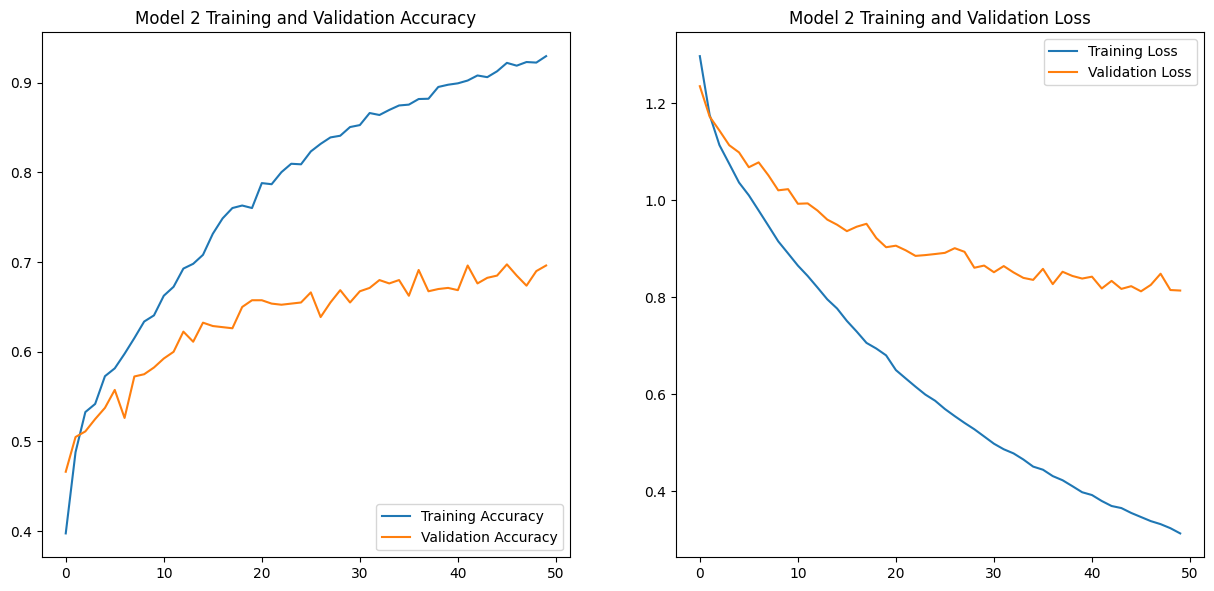

In [45]:
graph_history(history2,2, num_epochs=50)

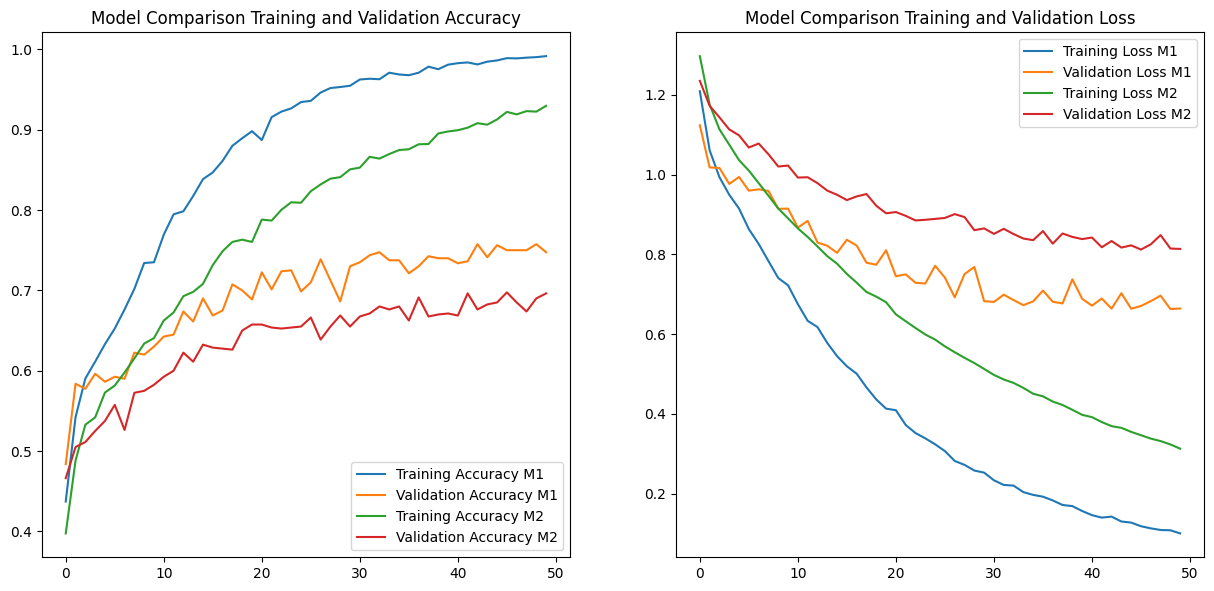

In [97]:
compare_history(history1, history2, 1,2)

Comparing models 1 and 2, it is evident that adding additional convolution layers does not increase the accuracy.

Model 3
1 convolution layers 
1 dense layer

doubled number of neurons for dense layer from model 1

In [46]:
model3 = Sequential()

model3.add(Conv2D(16,(3,3),1, activation="relu", input_shape=(224,224,3)))
model3.add(MaxPool2D())

model3.add(Flatten())

model3.add(Dense(256,activation="relu"))
model3.add(Dense(4, activation="softmax"))

model3.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 111, 111, 16)      0         
 ng2D)                                                           
                                                                 
 flatten_11 (Flatten)        (None, 197136)            0         
                                                                 
 dense_25 (Dense)            (None, 256)               50467072  
                                                                 
 dense_26 (Dense)            (None, 4)                 1028      
                                                                 
Total params: 50468548 (192.52 MB)
Trainable params: 50468548 (192.52 MB)
Non-trainable params: 0 (0.00 Byte)
_________

In [47]:
history3 = train_model(model3, sample, num_epochs=50)

Epoch 1/50
100/100 [==============================] - 32s 317ms/step - loss: 1.2050 - accuracy: 0.4581 - val_loss: 1.1359 - val_accuracy: 0.5213
Epoch 2/50
100/100 [==============================] - 31s 307ms/step - loss: 1.0409 - accuracy: 0.5531 - val_loss: 1.1029 - val_accuracy: 0.5175
Epoch 3/50
100/100 [==============================] - 33s 333ms/step - loss: 0.9643 - accuracy: 0.5969 - val_loss: 1.0337 - val_accuracy: 0.5625
Epoch 4/50
100/100 [==============================] - 34s 336ms/step - loss: 0.9311 - accuracy: 0.6097 - val_loss: 1.0427 - val_accuracy: 0.5663
Epoch 5/50
100/100 [==============================] - 32s 325ms/step - loss: 0.8536 - accuracy: 0.6628 - val_loss: 1.0477 - val_accuracy: 0.5362
Epoch 6/50
100/100 [==============================] - 33s 327ms/step - loss: 0.7992 - accuracy: 0.6963 - val_loss: 0.9737 - val_accuracy: 0.6012
Epoch 7/50
100/100 [==============================] - 33s 326ms/step - loss: 0.7579 - accuracy: 0.7194 - val_loss: 0.9797 - val_ac

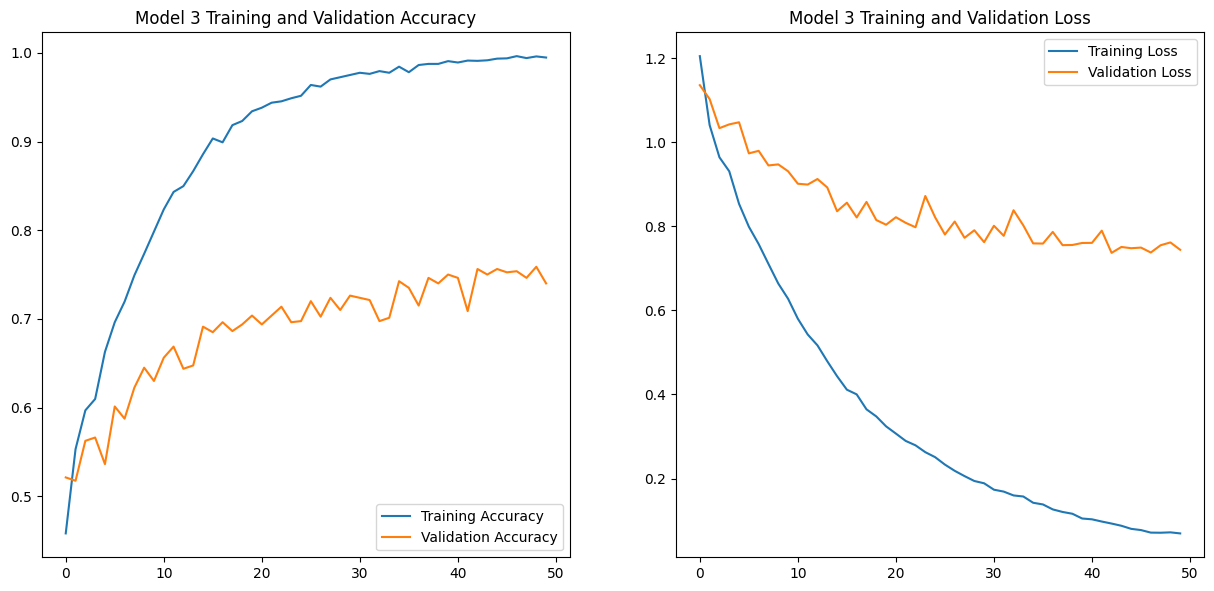

In [48]:
graph_history(history3, 3, num_epochs=50)

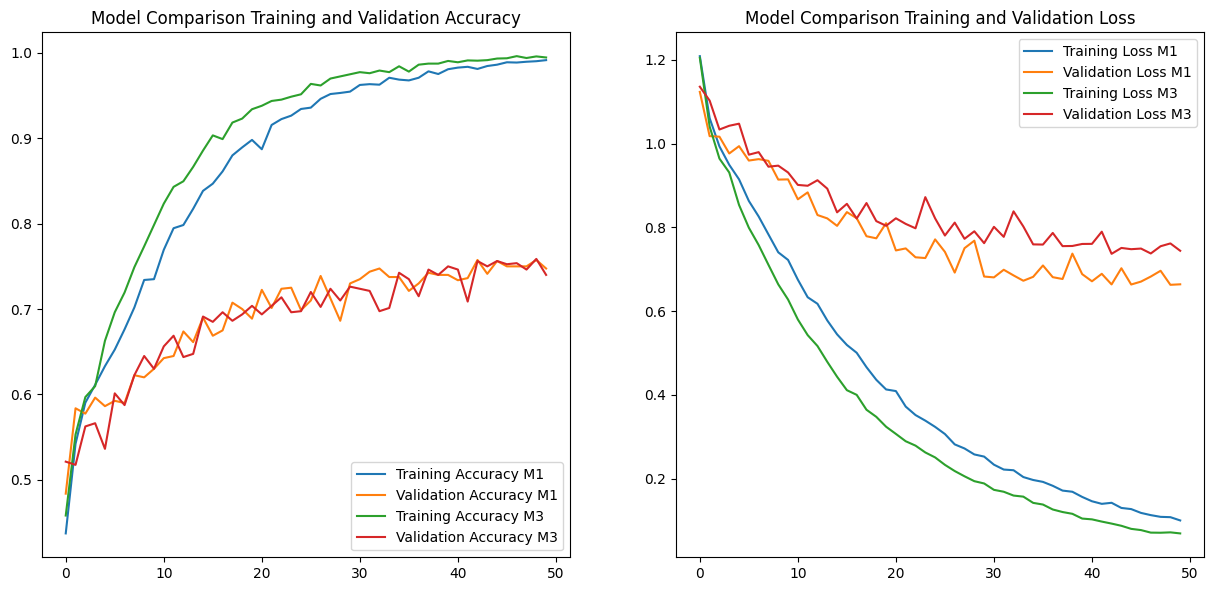

In [98]:
compare_history(history1, history3, 1,3)

Compared to model 1, model 3 also performs equivalently. The validation loss of Model 1 was also lower, and as the dense layer was doubled, we can go back to using model 1, as there is no large difference between the two.

Model 4
1 convolution layer
2 dense layers

added an additional dense layer from model 1

In [231]:
model4 = Sequential()

model4.add(Conv2D(16,(3,3),1, activation="relu", input_shape=(224,224,3)))
model4.add(MaxPool2D())

model4.add(Flatten())

model4.add(Dense(128,activation="relu"))
model4.add(Dense(128,activation="relu"))
model4.add(Dense(4, activation="softmax"))

model4.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d_36 (MaxPooli  (None, 111, 111, 16)      0         
 ng2D)                                                           
                                                                 
 flatten_22 (Flatten)        (None, 197136)            0         
                                                                 
 dense_48 (Dense)            (None, 128)               25233536  
                                                                 
 dense_49 (Dense)            (None, 128)               16512     
                                                                 
 dense_50 (Dense)            (None, 4)                 516       
                                                     

In [50]:
history4 = train_model(model4, sample, num_epochs=50)

Epoch 1/50
100/100 [==============================] - 22s 207ms/step - loss: 1.2471 - accuracy: 0.4219 - val_loss: 1.1624 - val_accuracy: 0.5088
Epoch 2/50
100/100 [==============================] - 20s 204ms/step - loss: 1.1050 - accuracy: 0.5284 - val_loss: 1.1324 - val_accuracy: 0.5200
Epoch 3/50
100/100 [==============================] - 19s 194ms/step - loss: 1.0330 - accuracy: 0.5709 - val_loss: 1.0669 - val_accuracy: 0.5550
Epoch 4/50
100/100 [==============================] - 20s 202ms/step - loss: 0.9987 - accuracy: 0.5834 - val_loss: 1.1245 - val_accuracy: 0.5025
Epoch 5/50
100/100 [==============================] - 20s 198ms/step - loss: 0.9602 - accuracy: 0.6056 - val_loss: 1.0440 - val_accuracy: 0.5587
Epoch 6/50
100/100 [==============================] - 20s 195ms/step - loss: 0.9204 - accuracy: 0.6263 - val_loss: 1.0606 - val_accuracy: 0.5625
Epoch 7/50
100/100 [==============================] - 19s 191ms/step - loss: 0.8811 - accuracy: 0.6481 - val_loss: 1.0240 - val_ac

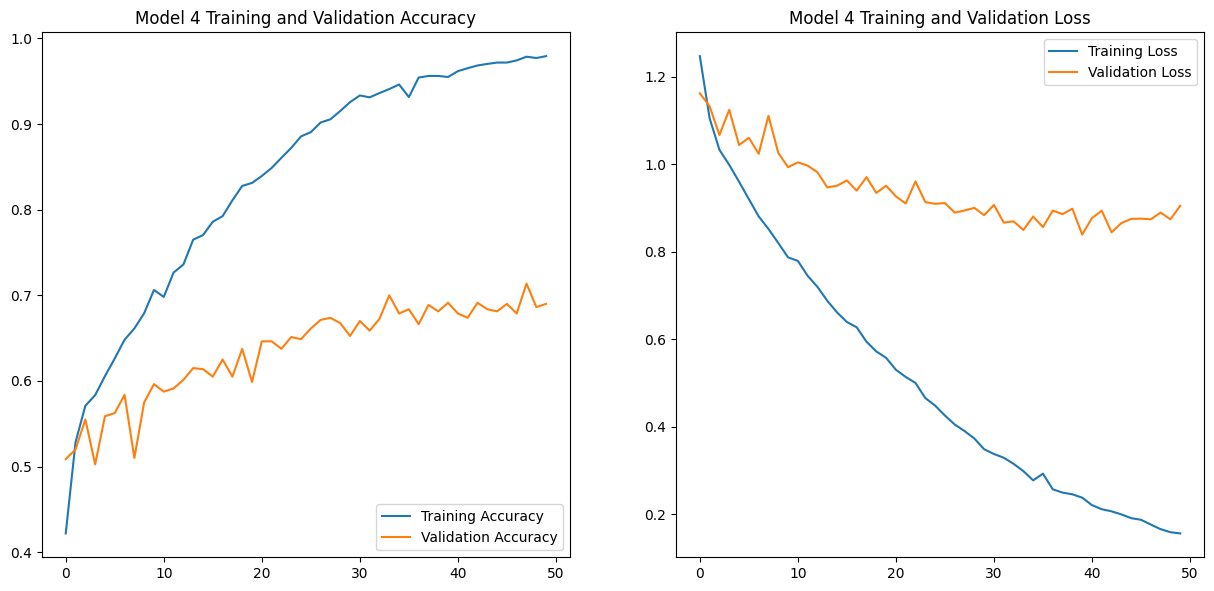

In [51]:
graph_history(history4,4, num_epochs=50)

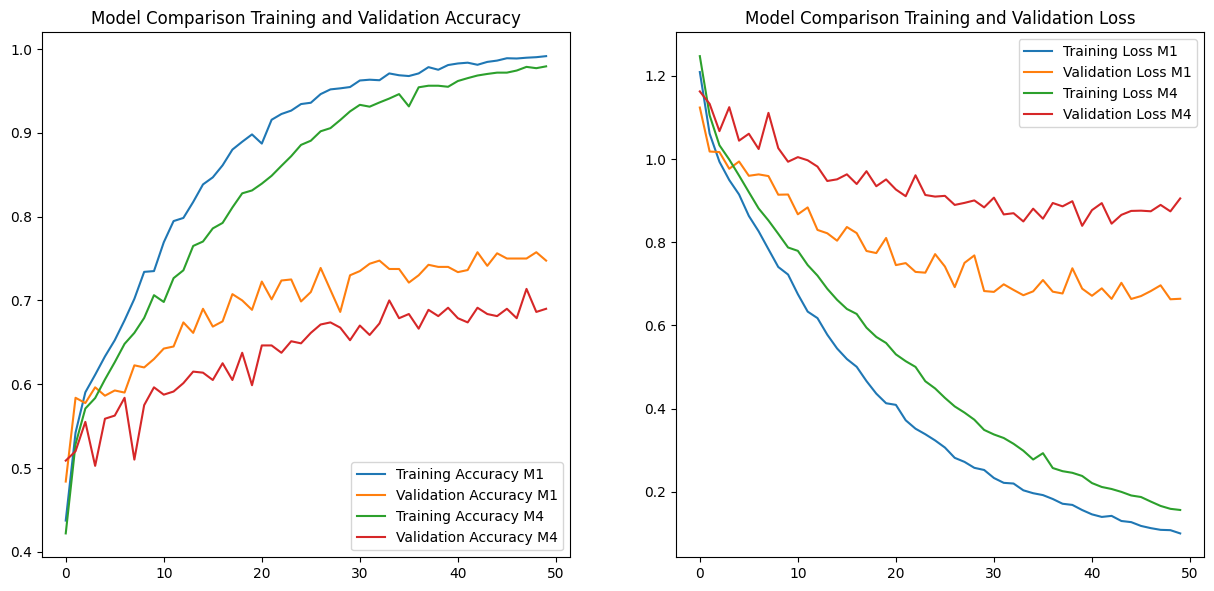

In [100]:
compare_history(history1, history4, 1,4)

Adding an additional dense layer to model 1 only decreased the accuracy, and increased the loss values on the validation set, therefore we continue using model 1.

Model 5
1 convolution layer
1 hidden layer

doubled the filters in the convolution layer from model 1

In [67]:
model5 = Sequential()

model5.add(Conv2D(32,(3,3),1, activation="relu", input_shape=(224,224,3)))
model5.add(MaxPool2D())

model5.add(Flatten())

model5.add(Dense(128,activation="relu"))
model5.add(Dense(4, activation="softmax"))

model5.summary()



Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 111, 111, 32)      0         
 ng2D)                                                           
                                                                 
 flatten_14 (Flatten)        (None, 394272)            0         
                                                                 
 dense_32 (Dense)            (None, 128)               50466944  
                                                                 
 dense_33 (Dense)            (None, 4)                 516       
                                                                 
Total params: 50468356 (192.52 MB)
Trainable params: 50468356 (192.52 MB)
Non-trainable params: 0 (0.00 Byte)
_________

In [68]:
history5 = train_model(model5, sample, num_epochs=50)

Epoch 1/50
100/100 [==============================] - 47s 462ms/step - loss: 1.2436 - accuracy: 0.4322 - val_loss: 1.1687 - val_accuracy: 0.5063
Epoch 2/50
100/100 [==============================] - 43s 429ms/step - loss: 1.0813 - accuracy: 0.5409 - val_loss: 1.1279 - val_accuracy: 0.4950
Epoch 3/50
100/100 [==============================] - 43s 430ms/step - loss: 1.0159 - accuracy: 0.5738 - val_loss: 1.1285 - val_accuracy: 0.5113
Epoch 4/50
100/100 [==============================] - 43s 430ms/step - loss: 0.9680 - accuracy: 0.5959 - val_loss: 1.0630 - val_accuracy: 0.5725
Epoch 5/50
100/100 [==============================] - 43s 429ms/step - loss: 0.9051 - accuracy: 0.6303 - val_loss: 1.0493 - val_accuracy: 0.5612
Epoch 6/50
100/100 [==============================] - 43s 429ms/step - loss: 0.8564 - accuracy: 0.6575 - val_loss: 0.9966 - val_accuracy: 0.5850
Epoch 7/50
100/100 [==============================] - 43s 432ms/step - loss: 0.8300 - accuracy: 0.6694 - val_loss: 1.0240 - val_ac

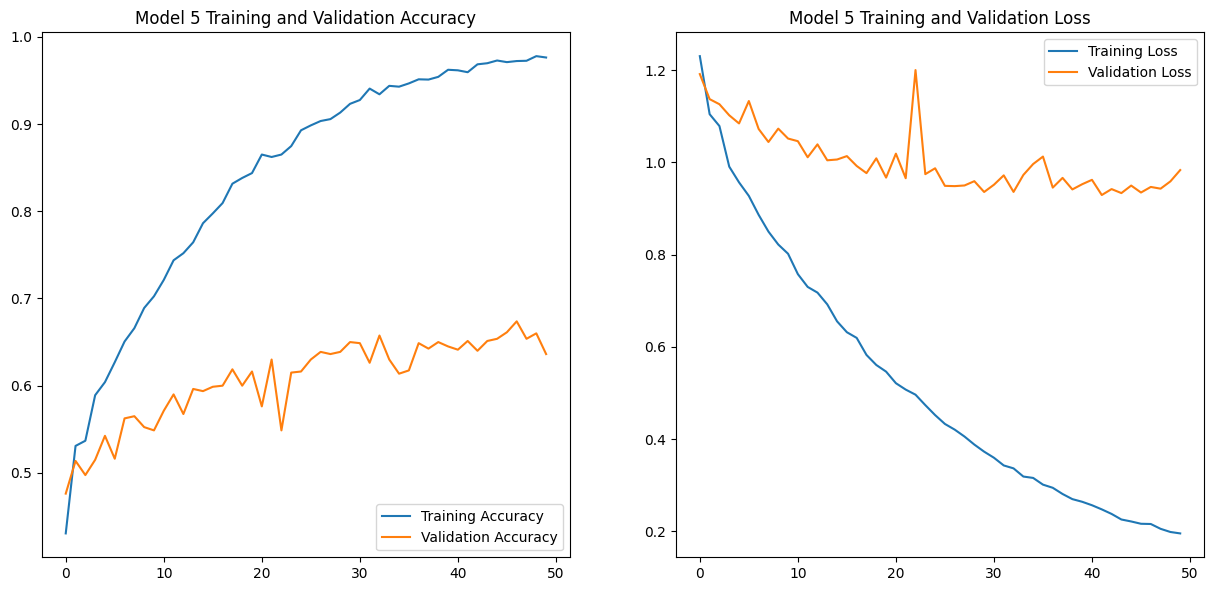

In [54]:
graph_history(history5, 5, num_epochs=50)

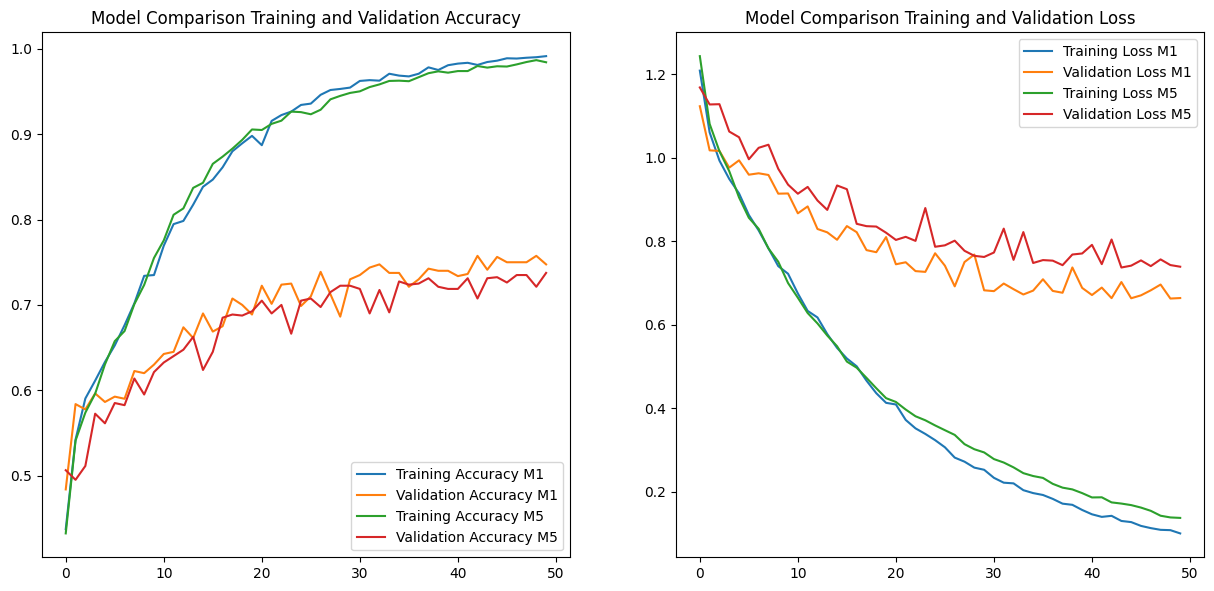

In [102]:
compare_history(history1, history5, 1,5)

Doubling the number of filters in the convolution layer in model 1 also yielded a slightly lower accuracy, and slightly higher loss for the validation set. Shall continue using model 1.

Model 6
1 convolution layer
1 dense layer

doubled training data set size from model 1

In [106]:
sample_8k = get_sample(data, sample_size=8000, test_size=0.2, random_state=0)

In [108]:
model1_8k = Sequential()

model1_8k.add(Conv2D(16,(3,3),1, activation="relu", input_shape=(224,224,3)))
model1_8k.add(MaxPool2D())

model1_8k.add(Flatten())

model1_8k.add(Dense(128,activation="relu"))
model1_8k.add(Dense(4, activation="softmax"))

model1_8k.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d_35 (MaxPooli  (None, 111, 111, 16)      0         
 ng2D)                                                           
                                                                 
 flatten_21 (Flatten)        (None, 197136)            0         
                                                                 
 dense_46 (Dense)            (None, 128)               25233536  
                                                                 
 dense_47 (Dense)            (None, 4)                 516       
                                                                 
Total params: 25234500 (96.26 MB)
Trainable params: 25234500 (96.26 MB)
Non-trainable params: 0 (0.00 Byte)
___________

In [109]:
history1_8k = train_model(model1_8k, sample_8k, num_epochs=50)

Epoch 1/50
200/200 [==============================] - 41s 203ms/step - loss: 1.1623 - accuracy: 0.4778 - val_loss: 1.0745 - val_accuracy: 0.5331
Epoch 2/50
200/200 [==============================] - 40s 201ms/step - loss: 1.0153 - accuracy: 0.5666 - val_loss: 1.0241 - val_accuracy: 0.5700
Epoch 3/50
200/200 [==============================] - 39s 195ms/step - loss: 0.9503 - accuracy: 0.6077 - val_loss: 1.0081 - val_accuracy: 0.5669
Epoch 4/50
200/200 [==============================] - 43s 215ms/step - loss: 0.8771 - accuracy: 0.6498 - val_loss: 0.9491 - val_accuracy: 0.6256
Epoch 5/50
200/200 [==============================] - 42s 210ms/step - loss: 0.8178 - accuracy: 0.6844 - val_loss: 0.9162 - val_accuracy: 0.6263
Epoch 6/50
200/200 [==============================] - 41s 206ms/step - loss: 0.7544 - accuracy: 0.7237 - val_loss: 0.8976 - val_accuracy: 0.6675
Epoch 7/50
200/200 [==============================] - 40s 202ms/step - loss: 0.6948 - accuracy: 0.7577 - val_loss: 0.8483 - val_ac

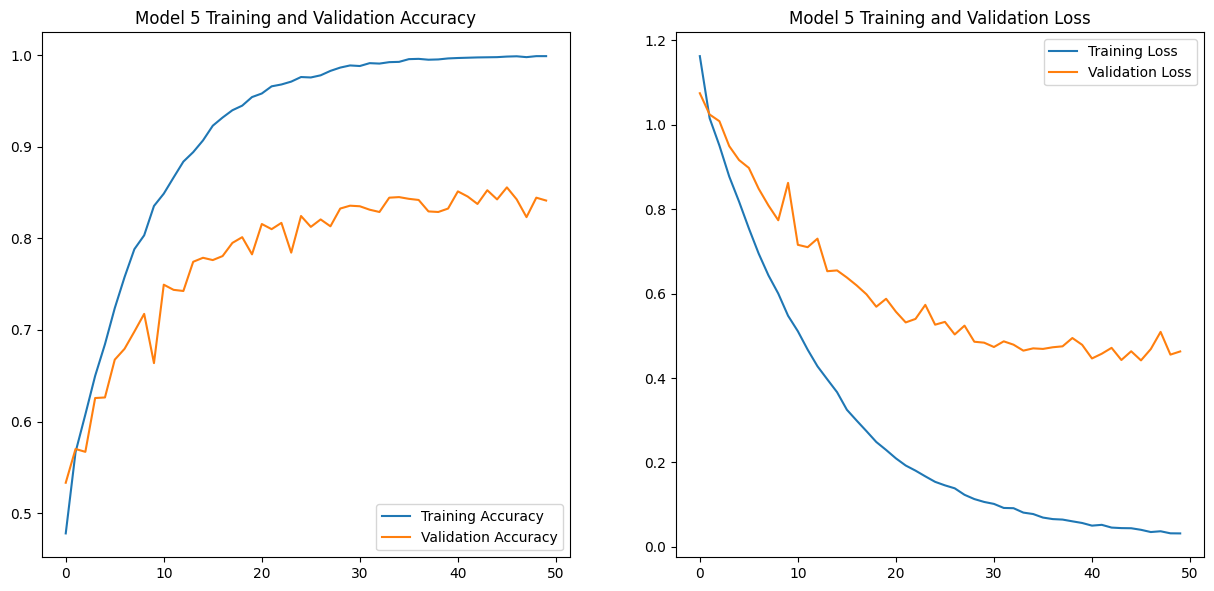

In [110]:
graph_history(history1_8k, 5, num_epochs=50)

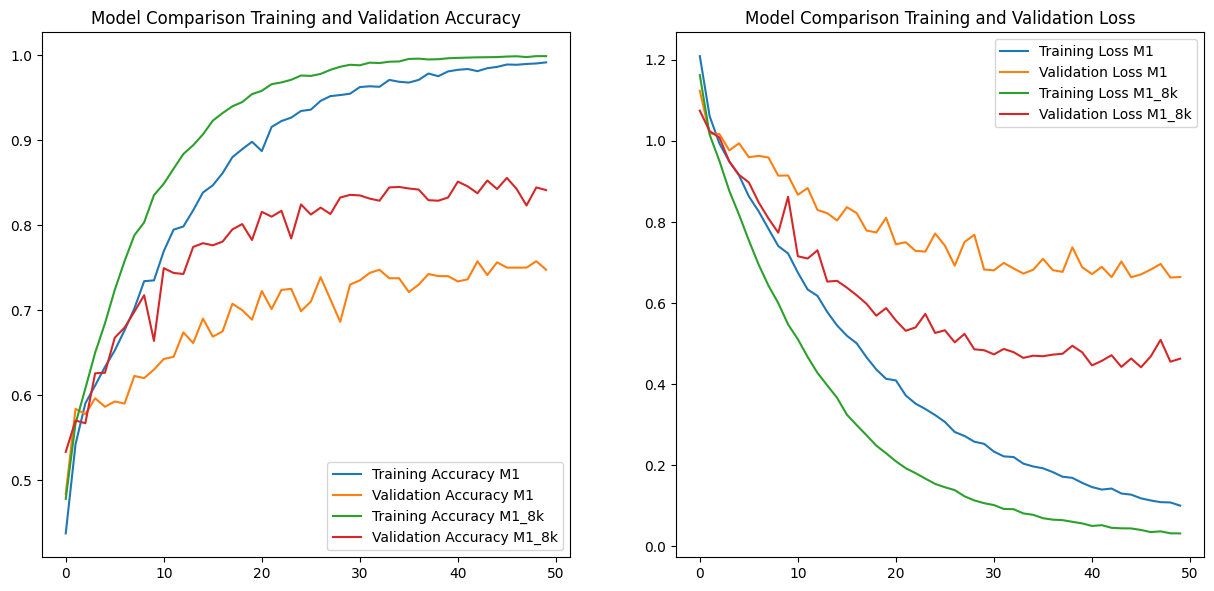

In [111]:
compare_history(history1, history1_8k, 1,'1_8k')

Can see that doubling the sample size used to train model 1 drastically increases its accuracy and decreases validation loss.

Model 7
1 convolution layer
1 dense layer

doubled training data set size from model 1

In [82]:
sample_16k = get_sample(data, sample_size=16000, test_size=0.2, random_state=0)

In [83]:
model1_16k = Sequential()

model1_16k.add(Conv2D(16,(3,3),1, activation="relu", input_shape=(224,224,3)))
model1_16k.add(MaxPool2D())

model1_16k.add(Flatten())

model1_16k.add(Dense(128,activation="relu"))
model1_16k.add(Dense(4, activation="softmax"))

model1_16k.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d_33 (MaxPooli  (None, 111, 111, 16)      0         
 ng2D)                                                           
                                                                 
 flatten_19 (Flatten)        (None, 197136)            0         
                                                                 
 dense_42 (Dense)            (None, 128)               25233536  
                                                                 
 dense_43 (Dense)            (None, 4)                 516       
                                                                 
Total params: 25234500 (96.26 MB)
Trainable params: 25234500 (96.26 MB)
Non-trainable params: 0 (0.00 Byte)
___________

In [84]:
history1_16k = train_model(model1_16k, sample_16k, num_epochs=50)

Epoch 1/50
400/400 [==============================] - 93s 228ms/step - loss: 1.1006 - accuracy: 0.5203 - val_loss: 1.0154 - val_accuracy: 0.5700
Epoch 2/50
400/400 [==============================] - 79s 197ms/step - loss: 0.9524 - accuracy: 0.6020 - val_loss: 0.9566 - val_accuracy: 0.5978
Epoch 3/50
400/400 [==============================] - 78s 196ms/step - loss: 0.8700 - accuracy: 0.6503 - val_loss: 0.8664 - val_accuracy: 0.6719
Epoch 4/50
400/400 [==============================] - 78s 196ms/step - loss: 0.7761 - accuracy: 0.7099 - val_loss: 0.8676 - val_accuracy: 0.6488
Epoch 5/50
400/400 [==============================] - 79s 198ms/step - loss: 0.6959 - accuracy: 0.7550 - val_loss: 0.7433 - val_accuracy: 0.7212
Epoch 6/50
400/400 [==============================] - 79s 197ms/step - loss: 0.6304 - accuracy: 0.7866 - val_loss: 0.6975 - val_accuracy: 0.7575
Epoch 7/50
400/400 [==============================] - 79s 196ms/step - loss: 0.5729 - accuracy: 0.8120 - val_loss: 0.6869 - val_ac

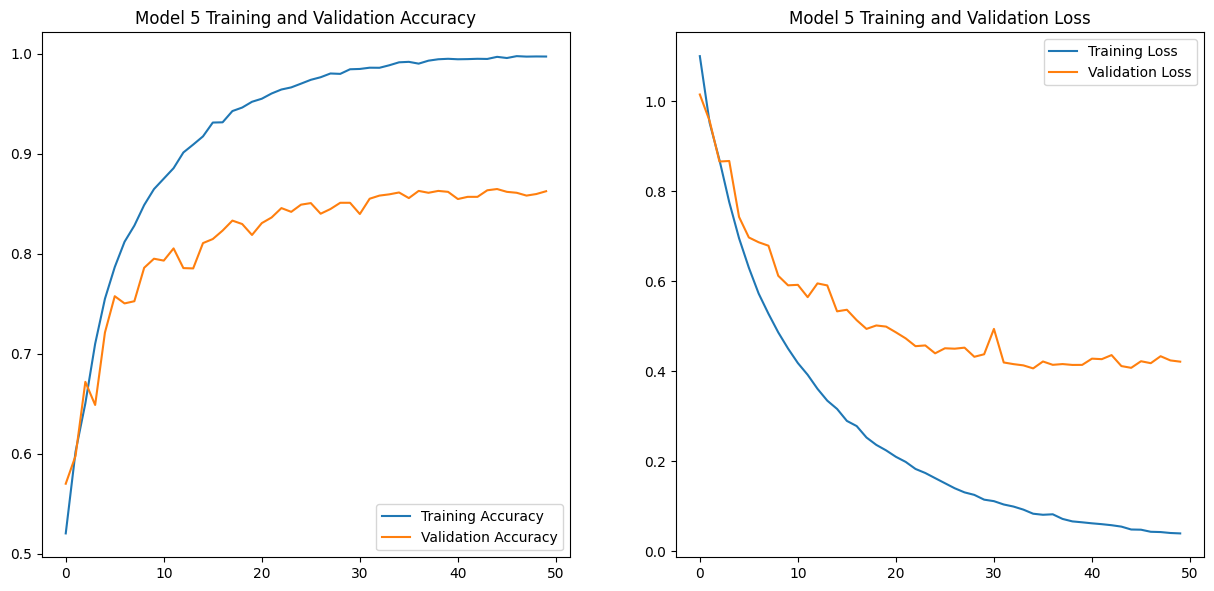

In [85]:
graph_history(history1_16k, 5, num_epochs=50)

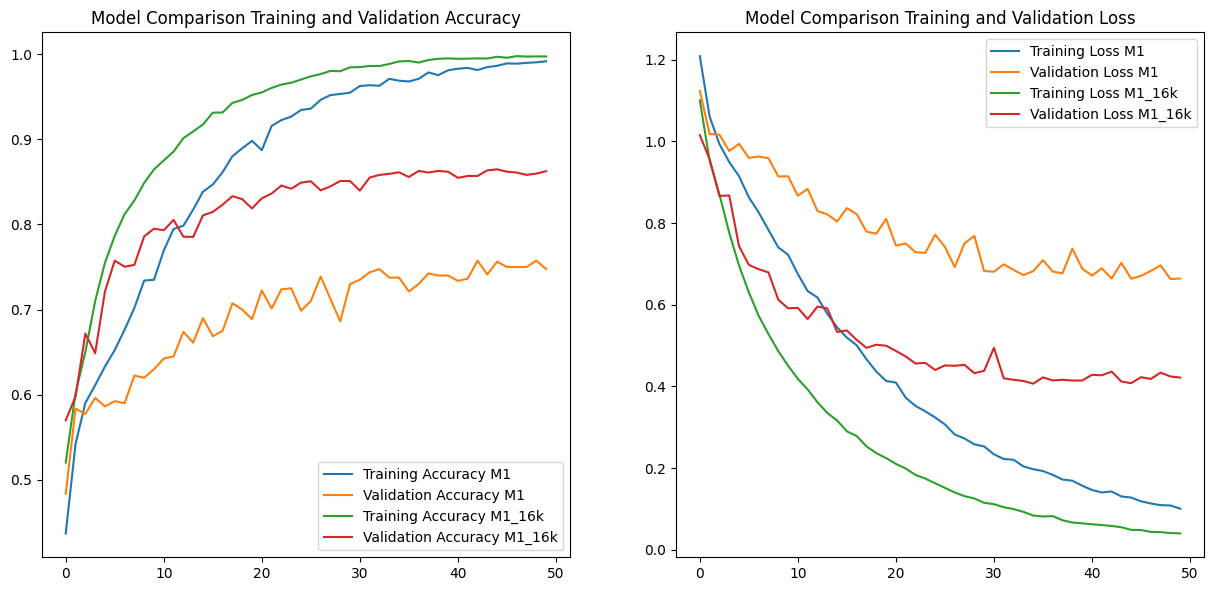

In [105]:
compare_history(history1, history1_16k, 1,'1_16k')

As expected, model 1 performs significanlty better the 16000 training datapoints.

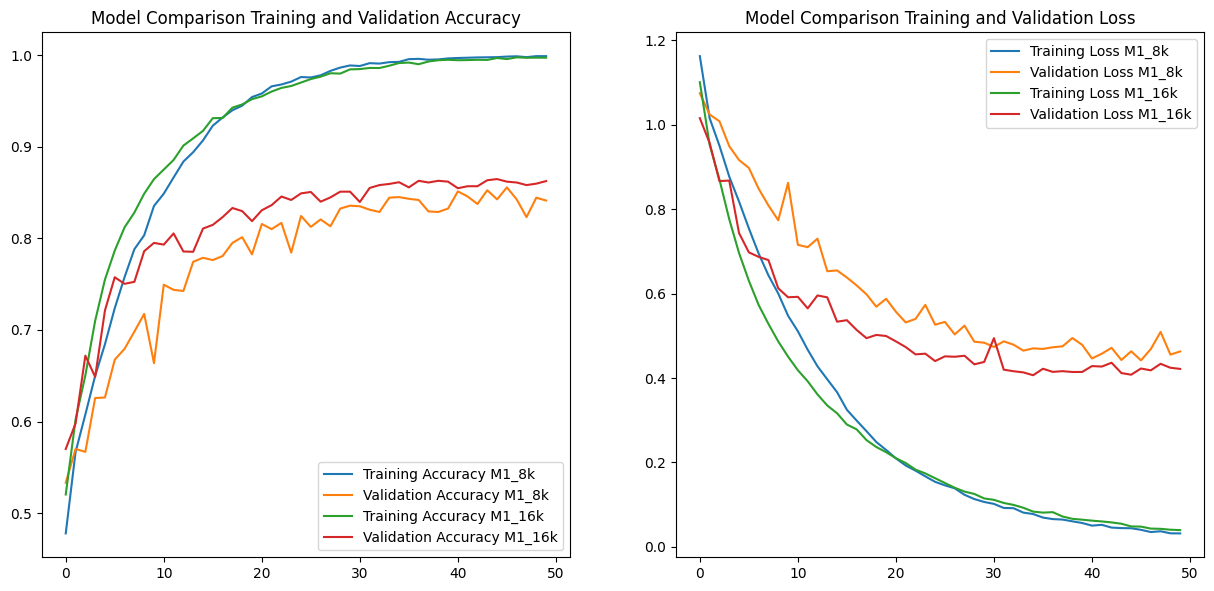

In [112]:
compare_history(history1_8k, history1_16k, '1_8k','1_16k')

When comparing 8k with 16k training points, we find that the larger set improves the model to a greater degree as expected.

In [173]:
x_test, y_test = sample_16k[2], sample_16k[3]
y_pred = model1_16k.predict(x_test)

y_pred_class = []
for i in range(0,len(y_pred)): y_pred_class.append(y_pred[i].argmax())

print(classification_report(y_test, y_pred_class, target_names=labels))

100/100 [==============================] - 3s 28ms/step
                       precision    recall  f1-score   support

          architecure       0.92      0.97      0.94       769
      art and culture       0.85      0.78      0.81       825
     food and d rinks       0.81      0.79      0.80       776
travel and  adventure       0.87      0.91      0.89       830

             accuracy                           0.86      3200
            macro avg       0.86      0.86      0.86      3200
         weighted avg       0.86      0.86      0.86      3200



Final model scored highest on architecture images, as shown, followed by travel and adventure, then art and culture, then food and drinks, with fairly similar precision and recall scores. This leaves the final model on a accuracy of 86% accurate. This could be further improved using additional data, however the resources required to train were unavailable at the time of testing.